In [58]:
# install updated version and import libraries
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [59]:
# import libraries
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import ddg_images
from IPython.display import display
from time import sleep

In [60]:
# view function documentation
??search_images_ddg

Signature: search_images_ddg(term, max_images=200)
Source:   
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]
File:      /opt/conda/lib/py

In [61]:
# create function to search for images
def search_images(image_name, max_images=100, test=False):
    if test==True:
        print(image_name)
        url = search_images_ddg(image_name, max_images=max_images)
    else:
        print(f'Searching for: {image_name}')
        url = search_images_ddg(image_name, max_images=max_images)
    return url

### Step 1: Get Data

cubism art


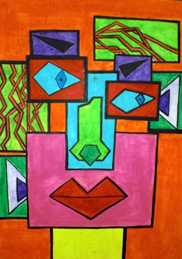

surrealism art


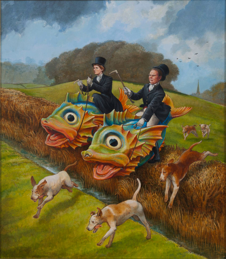

abstract expressionism art


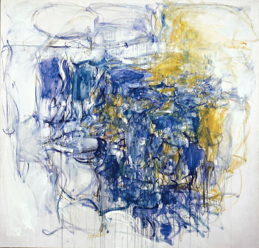

In [62]:
# view one image of various art styles  
style = 'cubism', 'surrealism', 'abstract expressionism'
for i in style:
    download_url(search_images(f'{i} art', max_images=1, test=True)[0], f'{i}.jpg', show_progress=False)
    img = Image.open(f'{i}.jpg').to_thumb(259, 259)
    display(img)

In [63]:
# build dataset 
style = 'cubism', 'surrealism', 'abstract expressionism'
path = Path('art')

for i in style:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=(search_images(f'{i} art', max_images=200)))

Searching for: cubism art
Searching for: surrealism art
Searching for: abstract expressionism art


In [64]:
# view number of images
print(f'Number of images: {len(get_image_files(path))}')

Number of images: 593


In [65]:
# verify images, remove and view failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'Failed images: {len(failed)}')

Failed images: 21


### Step 2: Train Model & Clean Data

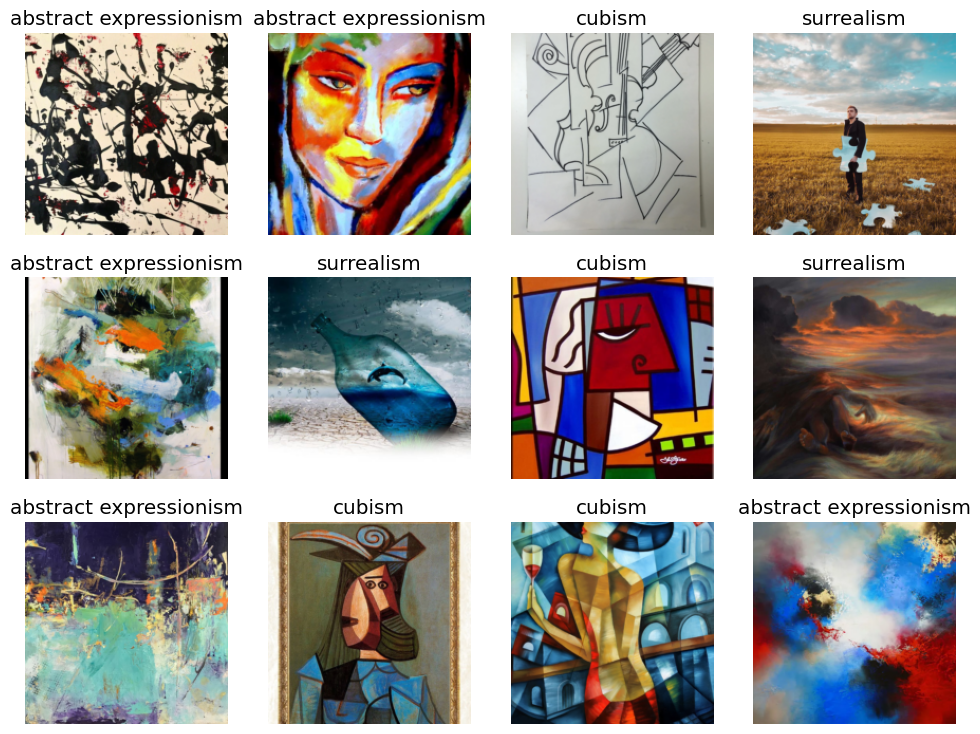

In [66]:
# create training and validation dataset
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192)]
).dataloaders(path, bs=32)

data.show_batch(max_n=12, nrows=3)


In [67]:
# train model before cleaning
learn = vision_learner(data, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.248306,0.645848,0.175439,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.476017,0.349260,0.122807,00:23
1,0.280222,0.326044,0.078947,00:23
2,0.196602,0.324095,0.061404,00:23
3,0.143382,0.305147,0.070175,00:22


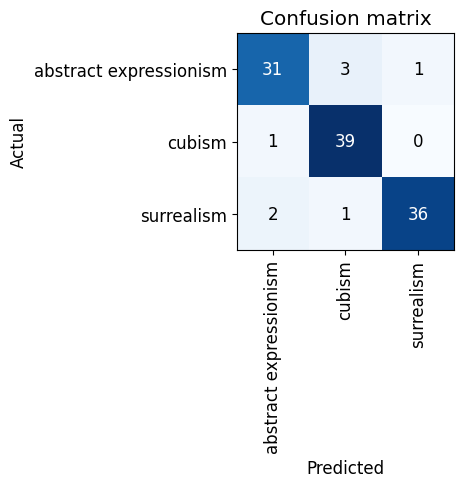

In [68]:
# use confusion matrix to view model performance 
# this will give an idea of what data needs cleaning
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

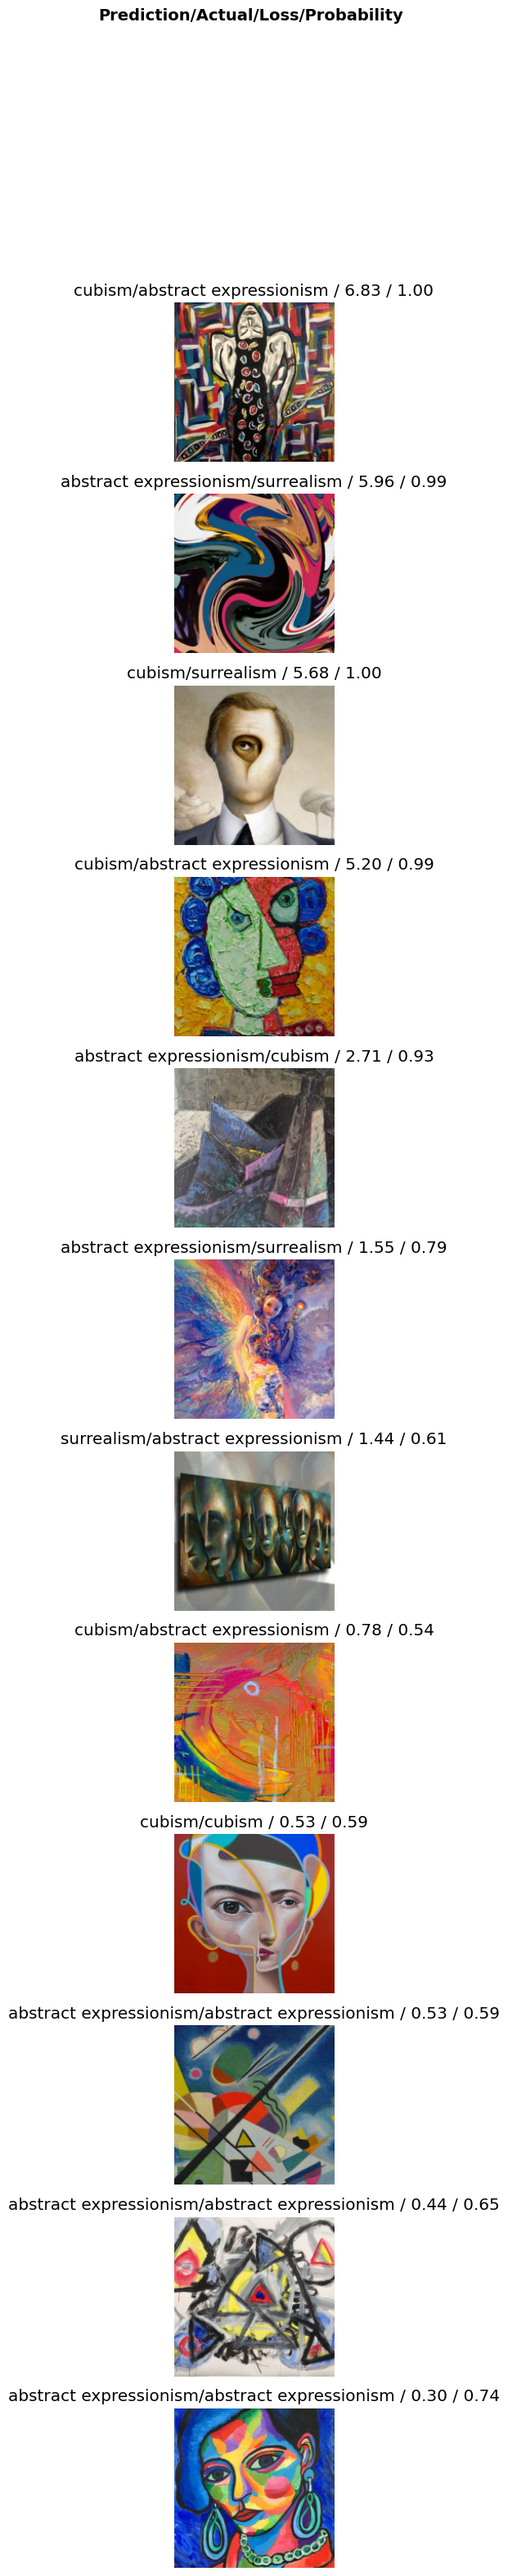

In [69]:
interp.plot_top_losses(12, nrows=12)